# Stroke Prediction Dataset
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset  
La idea sería predecir si el paciente es propenso a tener ("likely to have") un ACV (stroke) en base a características como género, hipertención, IMC, fumador, **SI SE CASÓ ALGUNA VEZ (?)**, etc.

## Índice
1. [AED](#aed)
    * [Visualización DataFrame](#df)
    * [Correlation Matrix](#corr)
    * [Violinplots](#violin)
    * [Scatterplot](#pair)
    * [Feature processing](#feat)
        * [Exploración BMI](#bmi)
\
&nbsp;
2. [Model Fitting](#model)
    * [Scaling](#scale)
    * [LinearRegression (ya aprendimos que no tiene sentido)](#lr)
    * [PCA](#pca)
    * [tSNE](#tsne)
    * [Manifold Learning](#manifold)
    * [LogisticRegression](#log)
    * [RandomForest](#rf)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 400
# mpl.rcParams.update({'font.size': 6})

# Análisis Exploratorio de Datos <a class="anchor" id="aed"></a>

## Visualización DataFrame <a class="anchor" id="df">

In [52]:
df = pd.read_csv("datasets/stroke/healthcare-dataset-stroke-data.csv")
df[df["work_type"]=="children"].stroke.value_counts()


0    685
1      2
Name: stroke, dtype: int64

In [4]:
df.drop("id", axis=1, inplace=True)

In [5]:
# Balance del dataset
cant_strokes = df.stroke.sum()
print(f"La proporción de datos con stroke positivo es del {cant_strokes/df.shape[0]*100:.1f} %")

La proporción de datos con stroke positivo es del 4.9 %


In [6]:
# Buscamos NaNs
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

---
No sabemos si conviene eliminar los pacientes con NaNs en BMI o reemplazar por el mean o algo así  
No quisiéramos perder casos con stroke positivo ya que no tenemos muchos

In [7]:
df_clean = df.dropna()
print(f"{'strokes en df':20} {df.stroke.sum()}")
print(f"{'strokes en df_clean':20} {df_clean.stroke.sum()}")

strokes en df        249
strokes en df_clean  209


Por ahora llenamos con la mediana

In [8]:
bmi_median = df.bmi.median()  # 28.1
df.bmi.fillna(bmi_median, inplace=True)

In [9]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [10]:
# Tenemos 3 variables numéricas
num_cols = ["age", "avg_glucose_level", "bmi"]  # El BMI es el IMC
num_df = df[num_cols]
# El resto son categóricas, algunas binarias y otras con varias opciones
cat_df = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
             'work_type', 'Residence_type', 'smoking_status', 'stroke']]

## Correlation Matrix <a class="anchor" id="corr">

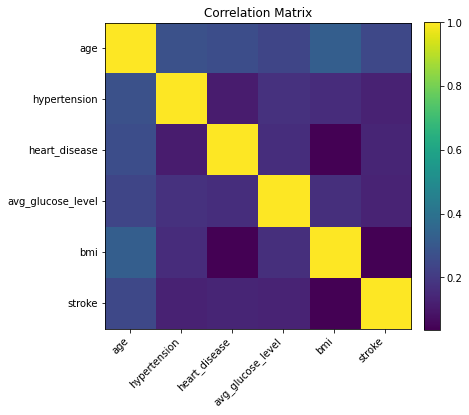

In [11]:
corr_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi','stroke']
plt.figure(figsize=(6, 6))
plt.imshow(df[corr_cols].corr())
plt.colorbar(fraction=0.0459, pad=0.04)  # Magia que encontré online para que la colorbar quede alineada
plt.title("Correlation Matrix")#, fontsize=6)
plt.xticks(np.arange(6), corr_cols, rotation=45, ha='right', va='top')#, fontsize=6)
plt.yticks(np.arange(6), corr_cols, rotation=0, ha='right', va='center')#, fontsize=6)
plt.show()

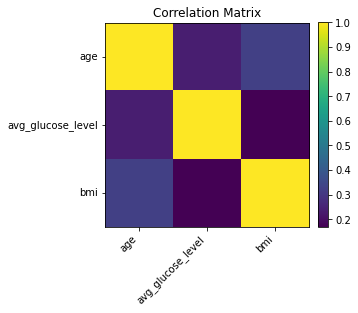

In [12]:
# Dejo las columnas numéricas, que tiene más sentido tiene dejar (creo)
plt.figure(figsize=(4, 4))
plt.imshow(num_df.corr())
plt.colorbar(fraction=0.0459, pad=0.04)  # Magia que encontré online para que la colorbar quede alineada
plt.title("Correlation Matrix")
plt.xticks(np.arange(3), num_df.columns, rotation=45, ha='right', va='top')
plt.yticks(np.arange(3), num_df.columns, rotation=0, ha='right', va='center')
plt.show()

## Violin plots <a class="anchor" id="violin">

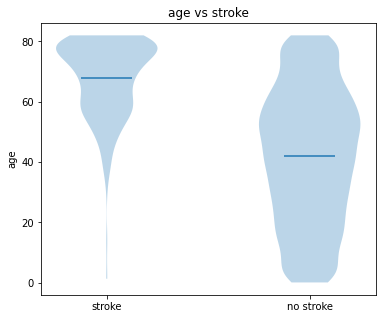

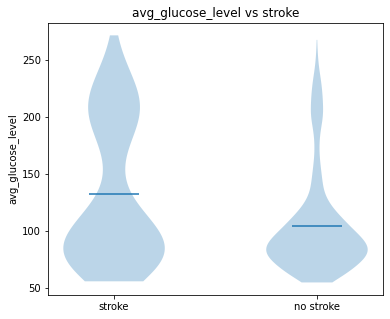

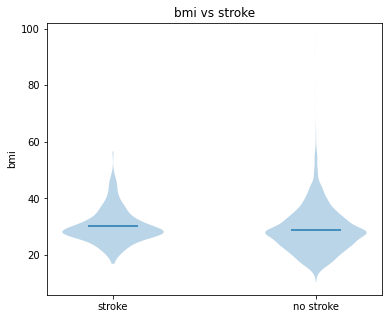

In [13]:
def violinplot(variable):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)

    categories = df["stroke"].unique()  # 0 y 1

    datos = [num_df.loc[(df["stroke"] == cat)][variable] for cat in categories]

    ax.violinplot(dataset=datos, showextrema=False, showmeans=True, points=1000)
    ax.xaxis.set_ticks(range(1, len(categories) + 1))
    ax.xaxis.set_ticklabels(["stroke", "no stroke"])
    ax.set_ylabel(variable)#, fontsize=6)
    plt.title(f"{variable} vs stroke")


for var in num_df.columns:
    violinplot(var)
plt.show()

## Scatter plot (pair plot) <a class="anchor" id="pair">

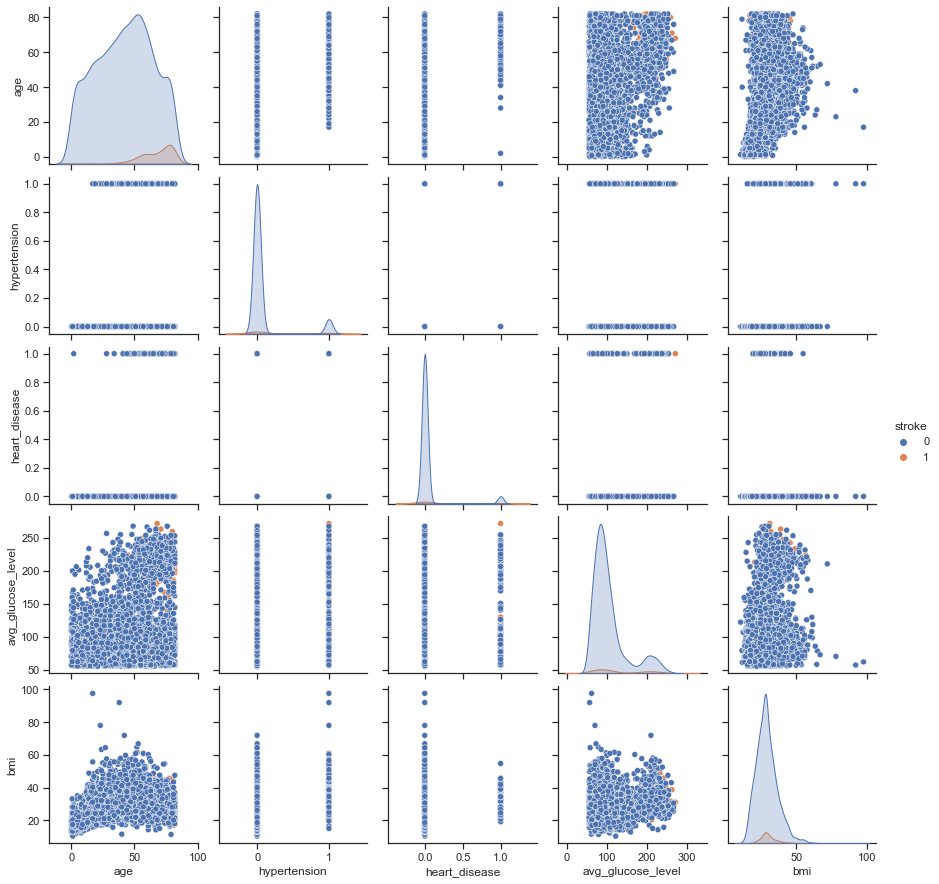

In [14]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="stroke")
plt.show()

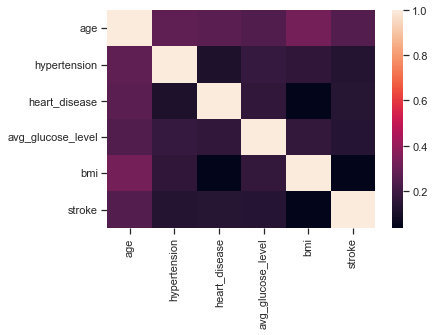

In [15]:
sns.heatmap(df.corr())
plt.show()

Otro problema son los Unknown en smoking_status

In [16]:
idx = df[(df["smoking_status"] == "Unknown")].index

In [17]:
df.drop(idx).stroke.value_counts()

0    3364
1     202
Name: stroke, dtype: int64

## Feature processing <a class="anchor" id="feat">

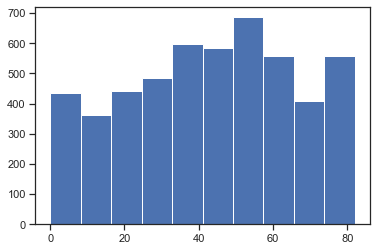

In [18]:
plt.hist(df.age)
plt.show()

In [19]:
smokers = {
    "never smoked": 0,
    "Unknown": 1,
    "formerly smoked": 2,
    "smokes": 3,
}

df["smoking_num"] = [smokers[cat] for cat in df.smoking_status]

In [20]:
df.work_type.unique()
# Orden de estrés: children --> Never_worked --> Private+Govt_job --> Self-employed => StdScaler
# Sino, usar un OneHotEncoder

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [21]:
work_types = {
    'Private': 2,
    'Self-employed': 3,
    'Govt_job': 2,
    'children': 0,
    'Never_worked': 1,
}

df["work_type_num"] = [work_types[cat] for cat in df.work_type]

In [22]:
df.Residence_type.unique()

array(['Urban', 'Rural'], dtype=object)

In [23]:
df.ever_married.unique()

array(['Yes', 'No'], dtype=object)

In [24]:
df["Residence_type_num"] = [0 if cat == "Rural" else 1 for cat in df.Residence_type]

In [25]:
df["gender_num"] = [0 if cat == "Male" else 1 for cat in df.gender]

In [26]:
df["ever_married_num"] = [0 if cat == "No" else 1 for cat in df.ever_married]

### Exploración BMI <a class="anchor" id="bmi">

Veamos como varía con la edad

In [27]:
edades = [10, 20, 30, 40, 50, 60, 70, 100]
for i, edad in enumerate(edades):
    if i == 0:
        print(f"Hasta: {edad:3} años - BMI: {df.bmi[(df.age<edad)&(df.age>0)].median():.2f}")
    else:
        print(f"Hasta: {edad:3} años - BMI: {df.bmi[(df.age<edad)&(df.age>edades[i-1])].median():.2f}")

Hasta:  10 años - BMI: 18.40
Hasta:  20 años - BMI: 23.60
Hasta:  30 años - BMI: 26.90
Hasta:  40 años - BMI: 29.30
Hasta:  50 años - BMI: 29.70
Hasta:  60 años - BMI: 30.30
Hasta:  70 años - BMI: 29.50
Hasta: 100 años - BMI: 28.10


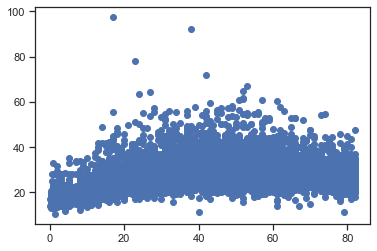

In [28]:
plt.scatter(df.age, df.bmi)
plt.show()

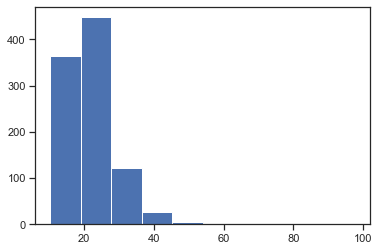

22.1109730848861


In [29]:
filtro_edad = df.age<20
plt.hist(df.bmi[filtro_edad])
plt.show()
print(df.bmi[filtro_edad].mean())

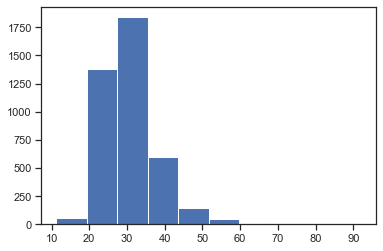

30.4966707466341


In [30]:
filtro_edad = df.age>20
plt.hist(df.bmi[filtro_edad])
plt.show()
print(df.bmi[filtro_edad].mean())

Ahora según género

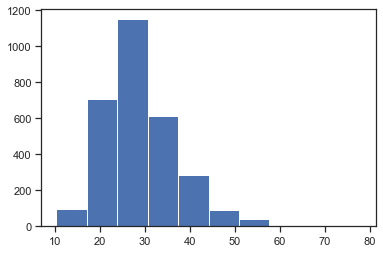

29.034468937875786


In [31]:
plt.hist(df.bmi[df.gender=="Female"])
plt.show()
print(df.bmi[df.gender=="Female"].mean())

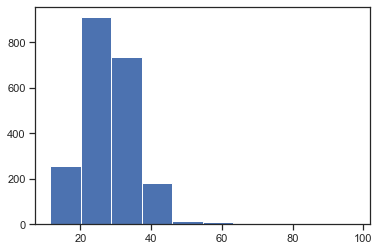

28.6209929078014


In [32]:
plt.hist(df.bmi[df.gender=="Male"])
plt.show()
print(df.bmi[df.gender=="Male"].mean())

Vemos que eventualmente seguro convendrá rellenar los NaNs de BMI teniendo en cuenta la edad en lugar de asignar la mediana de la columna entera.  
El nuevo dataframe quedó así:

In [33]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_num,work_type_num,Residence_type_num,gender_num,ever_married_num
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,2,2,1,0,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,0,3,0,1,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0,2,0,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3,2,1,1,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0,0,2,1,1,1
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,0,3,1,1,1
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,0,3,0,1,1
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,2,2,0,0,1


# Model Fitting <a class="anchor" id="model">

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [35]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'smoking_num', 'work_type_num',
       'Residence_type_num', 'gender_num', 'ever_married_num'],
      dtype='object')

In [36]:
cols =[
    'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
    'bmi', 'stroke', 'smoking_num', 'Residence_type_num',
    'gender_num', 'ever_married_num', 'work_type_num'
]
df_ml = df[cols]
train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)

In [37]:
x_train = train_df.drop(["stroke"], axis=1)
t_train = train_df["stroke"]
x_test = test_df.drop(["stroke"], axis=1)
t_test = test_df["stroke"]

### Scaling <a class="anchor" id="scale">

In [38]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [39]:
pd.DataFrame(x_train_scaled)[8].value_counts()

 0.726005    2677
-1.377402    1411
Name: 8, dtype: int64

## Linear Regression <a class="anchor" id="lr">

In [40]:
# No tiene sentido hacer una regresión lineal pero la hicimos jeje, abajo hacemos regresión logística
modelo = Pipeline([
    ("poly", PolynomialFeatures()),
    ("reg", LinearRegression(fit_intercept=False))
])

from sklearn.model_selection import GridSearchCV

hyperparameters = {'poly__degree': np.arange(1, 3)}
grilla = GridSearchCV(modelo, hyperparameters, refit=True, cv=6, verbose=2, n_jobs=-1)
grilla.fit(x_train_scaled, t_train)

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.7s finished


GridSearchCV(cv=6, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'poly__degree': array([1, 2])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [41]:
GridSearchCV?

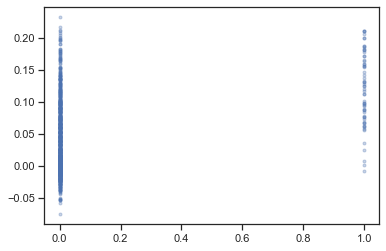

In [42]:
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

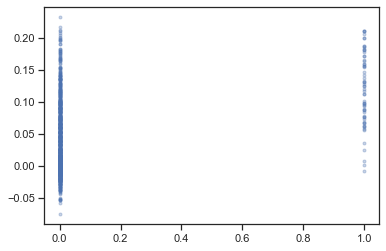

In [43]:
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

In [44]:
print(grilla.best_params_)

{'poly__degree': 1}


Aumentamos cantidad de folds

In [45]:
modelo = Pipeline([
    ("poly", PolynomialFeatures()),
    ("reg", LinearRegression(fit_intercept=False))
])

from sklearn.model_selection import GridSearchCV

hyperparameters = {'poly__degree': np.arange(1, 3)}
grilla = GridSearchCV(modelo, hyperparameters, refit=True, cv=30, verbose=3, n_jobs=-1)
grilla.fit(x_train_scaled, t_train)

Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished


GridSearchCV(cv=30, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'poly__degree': array([1, 2])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

{'poly__degree': 1}


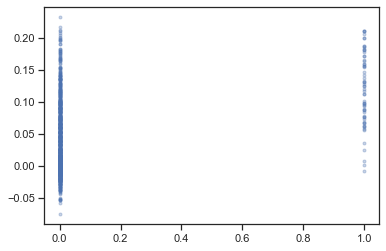

In [46]:
print(grilla.best_params_)
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error as mse
def rmse(x, t):
    return np.sqrt(mse(x, t))

In [48]:
ypred_train = elmejor.predict(x_train_scaled)
ypred_test = elmejor.predict(x_test_scaled)

In [49]:
print(f"RMSE train: {rmse(t_train, ypred_train):.3f}\nRMSE test:  {rmse(t_test, ypred_test):.3f}")

RMSE train: 0.201
RMSE test:  0.227


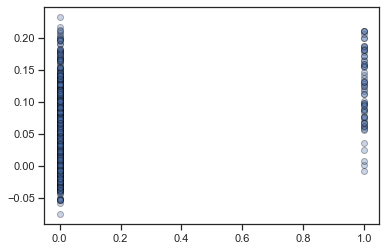

In [50]:
# plt.scatter(t_train, ypred_train)
plt.scatter(t_test, ypred_test, alpha=0.3, edgecolors="black")
plt.show()

## PCA <a class="anchor" id="pca">

In [51]:
#busco estudiar el PCA en 2 y 3 dimensiones para ver si se separan las categorías stroke y no stroke
df_ml
cols2 =[#saco stroke
    'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
    'bmi', 'smoking_num', 'Residence_type_num',
    'gender_num', 'ever_married_num', 'work_type_num'
]
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #instanceo pca 2D
df_train = df_ml[cols2] #nuevo data set sin stroke
X_pca = pca.fit_transform(df_train) #aplico pca sobre el nuevo data set

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


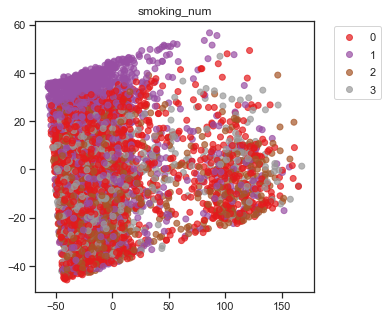

In [52]:
%matplotlib qt
#uso seaborn
df_ml["label"] = ["No Stroke" if cat == 0 else "Stroke" for cat in df_ml.stroke]#creo una nueva columna para poder setear el label en el scatter
fig, ax = plt.subplots(figsize=(5,5))
#ax = sns.scatterplot(*X_pca.T, hue=df_ml["label"] ,legend='full',
                     #palette = {"No Stroke":"blue", "Stroke":"red"})#ploteo, con palette defino un color para cada elemento de los labels
ax.legend(loc='lower left')
etiqueta = "smoking_num"
scat = ax.scatter(*X_pca.T, c=df_ml[etiqueta]/2, alpha=0.7, cmap=plt.cm.Set1)
plt.title(etiqueta)
f = lambda x: 2*x
#cb = plt.colorbar()
plt.legend(*scat.legend_elements(func=f), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [53]:
pca.explained_variance_ratio_ #que porcentaje de la varianza hay en cada componente
np.diag(np.cov(df_train.T))

array([5.11331792e+02, 8.79755192e-02, 5.11044743e-02, 2.05060082e+03,
       5.92832599e+01, 1.14879536e+00, 2.49984544e-01, 2.42633295e-01,
       2.25656845e-01, 6.89733324e-01])

In [54]:
pca.components_ #como es cada componente

array([[ 1.53718110e-01,  1.24913433e-03,  8.82976576e-04,
         9.87569535e-01,  3.25667751e-02,  7.24965865e-04,
        -4.11213693e-05, -5.50971860e-04,  2.13186576e-03,
         2.97402766e-03],
       [-9.81054854e-01, -3.11656691e-03, -2.23625947e-03,
         1.56459568e-01, -1.10423893e-01, -3.62905555e-03,
        -3.64969039e-04, -1.05255387e-03, -1.41453184e-02,
        -2.50823714e-02]])

In [55]:
#invierto y calculo la diferencia al reducir la dimensionalidad
X_inv = pca.inverse_transform(X_pca)
print(np.allclose(X_inv, df_train))

np.mean(np.sum(np.square(X_inv - df_train), axis=1))

False


54.1578672082691

In [56]:
#hago el PCA 3D
from mpl_toolkits.mplot3d import Axes3D
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(df_train)

In [74]:
#grafico el PCA 3D
fig = plt.figure(figsize=(15,15))

etiqueta = "stroke"
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=df_ml[etiqueta], alpha=0.3, cmap=plt.cm.Set1, s=10)
ax.view_init(10, -70)
plt.title(etiqueta)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2) #seteo las legends, 0 = "No Stroke", 1 = "Stroke"
plt.show()

In [75]:
#me fijo que tan buenas son estas reducciones. Si tuviera todas las componentes cumsum = 1
cumsum = np.cumsum(pca.explained_variance_ratio_) #this tells us how much information is retained if we stop at each dimension
cumsum3 = np.cumsum(pca3.explained_variance_ratio_)
print(f"2 Componentes: {cumsum[1]}\n 3 Componentes: {cumsum3[2]}")

2 Componentes: 0.9793558348187683
 3 Componentes: 0.9991512060020247


## tSNE <a class="anchor" id="tsne">

In [59]:
from sklearn.manifold import TSNE
#pruebo tSNE a ver si separa los labels 
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(df_train)

In [80]:
#lo grafico
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

scat = ax.scatter(*X_reduced_tsne.T, c=df_ml[etiqueta], s=50, cmap=plt.cm.Set1, 
                  edgecolors='None', alpha=0.3)
plt.title(etiqueta)
plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [61]:
#Ahora pruebo tSNE 3D
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(df_train)#fit a subset to reduce computing time

In [84]:
#lo grafico
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
etiqueta = "work_type_num"
scat = ax.scatter(*X_reduced_tsne_3d.T, c=df_ml[etiqueta], s=20, cmap=plt.cm.Set1, 
                  edgecolors='None', alpha=0.7)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

## Manifold Learning <a class="anchor" id="manifold">

In [85]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=3, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(df_train)

In [91]:
etiqueta = "work_type_num"
plt.title(etiqueta, fontsize=14)
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_ml[etiqueta], cmap=plt.cm.Set1)

# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [68]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=df_ml["stroke"], s=20, cmap=plt.cm.seismic, 
                  edgecolors='None', alpha=0.7)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("stroke")
plt.show()


## Logistic Regression <a class="anchor" id="log">

In [ ]:
# Pruebo Logistig Regression
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(x_train_scaled, t_train)
ypred_log = logistic_model.predict(x_test_scaled)

In [ ]:
print(f"RMSE LogisticRegression model: {rmse(ypred_log, t_test):.3f}")

In [ ]:
plt.scatter(t_test, ypred_log)
plt.show()

In [ ]:
(t_test == ypred_log).value_counts()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(t_test, ypred_log))

In [ ]:
df_log = pd.DataFrame({"t_test": t_test, "t_pred": ypred_log})

In [ ]:
# Me fijo si atinó prediciendo un 1
df_log[df_log["t_test"]==1]["t_pred"].sum()

In [ ]:
# Me fijo si predijo algún 1, mal o bien
df_log[df_log["t_pred"]==1]

In [ ]:
roc_auc_score(t_test, ypred_log)

# ‘roc_auc_score’ of 0.5 means the model is unable to distinguish between classes. Values close to 1.0 correspond to a strong separation between classes. The ‘f1_score’ is the harmonic mean of precision and recall. Similar to ‘roc_auc_score’, a perfect ‘f1_score’ is equal to 1.0:

## Random Forest <a class="anchor" id="rf">

In [ ]:
from sklearn.ensemble import RandomForestClassifier
reg_rf = RandomForestClassifier()
reg_rf.fit(x_train_scaled, t_train)

In [ ]:
ypred_rf = reg_rf.predict(x_test_scaled)
print(classification_report(t_test, ypred_rf))

In [ ]:
print("roc_auc_score: ", roc_auc_score(t_test, ypred_rf))

In [ ]:
df_rf = pd.DataFrame({"t_test": t_test, "t_pred": ypred_rf})

In [ ]:
df_rf[df_rf["t_pred"]==1]

In [ ]:
print(f"RMSE Random Forest: {rmse(t_test, ypred_rf):.3f}")